In [537]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [538]:
plt.rcParams["figure.figsize"] = (6,6)

In [539]:
import numpy as np
import pandas as pd
import seaborn as sns

In [540]:
from tqdm import tqdm
import pathlib

In [541]:
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score as r2

from statsmodels.tsa.stattools import adfuller as adf

In [542]:
DATA_DIR = pathlib.Path("./")

In [543]:
RS = 289475

### Версии:

- `numpy`: 1.16.3
- `pandas`: 0.24.2
- `sklearn`: 0.21.2

# Загрузка данных

In [544]:
train_target = pd.read_csv(DATA_DIR.joinpath("pet_target_train.csv"), index_col="date", parse_dates=["date"])
test_target = pd.read_csv(DATA_DIR.joinpath("pet_test_timestamps.csv"), index_col="date", parse_dates=["date"])
daily = pd.read_csv(DATA_DIR.joinpath("pet_daily.csv"), index_col="date", parse_dates=["date"])
weekly = pd.read_csv(DATA_DIR.joinpath("pet_weekly.csv"), index_col="date", parse_dates=["date"])

In [545]:
train_target.head()

,pet
date,
2004-06-01,961.25
2004-07-01,962.00
2004-08-01,1053.75
2004-09-01,1180.00
2004-10-01,1240.00


In [546]:
daily.head()

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min
date,,,,,,,,
2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770
2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769
2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768
2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767
2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766


In [547]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4221 entries, 2002-07-01 to 2019-06-28
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brent_close   4221 non-null   float64
 1   brent_open    4221 non-null   float64
 2   brent_max     4221 non-null   float64
 3   brent_min     4221 non-null   float64
 4   USDCNY_close  4221 non-null   float64
 5   USDCNY_open   4221 non-null   float64
 6   USDCNY_max    4221 non-null   float64
 7   USDCNY_min    4221 non-null   float64
dtypes: float64(8)
memory usage: 296.8 KB


In [548]:
weekly.head()

,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
date,,,,,,
2004-04-30,NaN,669.0,735.0,NaN,622.5,860.0
2004-05-07,NaN,680.0,730.0,NaN,650.0,860.0
2004-05-14,NaN,664.0,720.0,NaN,650.0,857.5
2004-05-21,NaN,657.0,722.5,NaN,650.0,852.5
2004-05-28,NaN,667.5,735.0,NaN,650.0,857.5


In [549]:
weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 799 entries, 2004-04-30 to 2019-08-16
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   paraxylene_CHN_USD       744 non-null    float64
 1   paraxylene_RT_USD        782 non-null    float64
 2   paraxylene_SEA_USD       778 non-null    float64
 3   pta_NEA_USD              292 non-null    float64
 4   ethylene_glycol_EU_EUR   782 non-null    float64
 5   ethylene_glycol_CHN_USD  767 non-null    float64
dtypes: float64(6)
memory usage: 43.7 KB


Text(0.5, 1, 'PET prices')

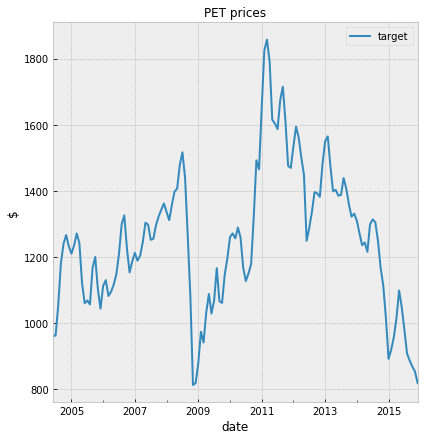

In [550]:
train_target["pet"].plot(ax=plt.gca(), label="target")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("PET prices", fontsize=12)

# Признаки

## Дневные данные

In [551]:
dfts = daily.resample("D").mean()#появились выходные дни
wfts = weekly.resample("D").ffill()#добавились дни между неделями
fts = dfts.join(wfts)

In [552]:
fts.isnull().sum()

brent_close                1986
brent_open                 1986
brent_max                  1986
brent_min                  1986
USDCNY_close               1986
USDCNY_open                1986
USDCNY_max                 1986
USDCNY_min                 1986
paraxylene_CHN_USD         1054
paraxylene_RT_USD           788
paraxylene_SEA_USD          816
pta_NEA_USD                4218
ethylene_glycol_EU_EUR      788
ethylene_glycol_CHN_USD     893
dtype: int64

__Убираем индексы, чтобы в дальнейшем соединить таблицы__

In [553]:
fts = fts.reset_index() 
train_target = train_target.reset_index()

__Добавляем столбец key, по которому будем объединять дни и недели__

In [554]:
fts["key"] = fts["date"].apply(lambda x: str(x.year) + "_" + str(x.month)
                                if x.month > 9 else str(x.year) + "_0" + str(x.month))
train_target["key"] = train_target["date"].apply(lambda x: str(x.year) + "_" + str(x.month)
                                if x.month > 9 else str(x.year) + "_0" + str(x.month))

In [555]:
fts_grouped = fts.drop("date", axis=1).groupby("key").mean().reset_index()

In [556]:
fts_grouped

,key,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
0,2002_07,25.680870,25.663478,25.917826,25.394348,8.276796,8.276796,8.276796,8.276796,NaN,NaN,NaN,NaN,NaN,NaN
1,2002_08,26.405500,26.307000,26.672500,26.056000,8.276730,8.276730,8.276730,8.276730,NaN,NaN,NaN,NaN,NaN,NaN
2,2002_09,28.290476,28.297619,28.625238,28.000000,8.276986,8.276986,8.276986,8.276986,NaN,NaN,NaN,NaN,NaN,NaN
3,2002_10,27.358261,27.471304,27.710435,27.105217,8.277039,8.277039,8.277039,8.277039,NaN,NaN,NaN,NaN,NaN,NaN
4,2002_11,24.226500,24.375500,24.694500,24.018000,8.277085,8.277085,8.277085,8.277085,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019_02,64.791176,64.534706,65.370000,63.848235,6.738694,6.738112,6.748841,6.724906,1103.000000,1000.000000,1093.000000,842.500000,630.875000,614.500000
200,2019_03,67.027619,66.905238,67.570476,66.253333,6.713748,6.712743,6.720933,6.703271,1093.741935,1005.322581,1083.741935,846.225806,625.564516,636.629032
201,2019_04,71.628571,71.375238,72.131429,70.845714,6.717619,6.715943,6.723371,6.709171,1019.300000,936.666667,1009.300000,841.683333,602.750000,601.700000
202,2019_05,70.134286,70.450952,71.167619,69.221905,6.858410,6.849524,6.866033,6.842395,893.451613,805.322581,883.451613,816.419355,575.322581,555.903226


In [557]:
df = pd.merge(fts_grouped, train_target, how="left", on="key") #код для объединения

In [558]:
train_target

,date,pet,key
0,2004-06-01,961.250,2004_06
1,2004-07-01,962.000,2004_07
2,2004-08-01,1053.750,2004_08
3,2004-09-01,1180.000,2004_09
4,2004-10-01,1240.000,2004_10
...,...,...,...
134,2015-08-01,908.125,2015_08
135,2015-09-01,886.250,2015_09
136,2015-10-01,868.500,2015_10
137,2015-11-01,853.750,2015_11


In [559]:
df.columns

Index(['key', 'brent_close', 'brent_open', 'brent_max', 'brent_min',
       'USDCNY_close', 'USDCNY_open', 'USDCNY_max', 'USDCNY_min',
       'paraxylene_CHN_USD', 'paraxylene_RT_USD', 'paraxylene_SEA_USD',
       'pta_NEA_USD', 'ethylene_glycol_EU_EUR', 'ethylene_glycol_CHN_USD',
       'date', 'pet'],
      dtype='object')

__Сдвинем все признаки на 2 месяца вперед, так как мы можем использовать данные не позже 10-го числа предыдущего месяца для прогнозирования значений целевой переменной.__

__Также создадим лаги целевой переменной.__

In [560]:
df["pet_feat"] = df["pet"].shift(2) #сдвигаем на 2 месяца вперед

In [561]:
for col in df.columns:
    if col not in ["key", "pet", "pet_feat", "date"]:
        df[col] = df[col].shift(2) # сдвигаем на 2 месяца вперед

In [562]:
for col in df.columns:
    if col not in ["key", "pet", "date"]:
        for lg in range(1, 7):
            df[col+"_lag_"+str(lg)] = df[col].shift(lg)        

__Посмотрим на кол-во пропусков.__

In [563]:
train_target

,date,pet,key
0,2004-06-01,961.250,2004_06
1,2004-07-01,962.000,2004_07
2,2004-08-01,1053.750,2004_08
3,2004-09-01,1180.000,2004_09
4,2004-10-01,1240.000,2004_10
...,...,...,...
134,2015-08-01,908.125,2015_08
135,2015-09-01,886.250,2015_09
136,2015-10-01,868.500,2015_10
137,2015-11-01,853.750,2015_11


__Оставим наблюдения, начиная с февраля 2005__

__Делаем это, чтобы убрать пропуски, появившиеся из-за создания лагов.__

In [564]:
df["key"] = df["key"].apply(lambda x: int(x)) #приводим к числу

In [565]:
df = df[df["key"] > 200501]

In [566]:
df.head()

,key,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,paraxylene_CHN_USD,...,ethylene_glycol_CHN_USD_lag_3,ethylene_glycol_CHN_USD_lag_4,ethylene_glycol_CHN_USD_lag_5,ethylene_glycol_CHN_USD_lag_6,pet_feat_lag_1,pet_feat_lag_2,pet_feat_lag_3,pet_feat_lag_4,pet_feat_lag_5,pet_feat_lag_6
31,200502,40.290000,40.559000,41.233500,39.505500,8.2765,8.2765,8.2765,8.2765,NaN,...,1160.166667,1043.387097,883.951613,853.416667,1266.25,1240.00,1180.00,1053.75,962.00,961.25
32,200503,44.415789,44.145263,44.966842,43.463158,8.2765,8.2765,8.2765,8.2765,967.000000,...,1170.000000,1160.166667,1043.387097,883.951613,1232.50,1266.25,1240.00,1180.00,1053.75,962.00
33,200504,46.271176,46.165294,46.730000,45.675294,8.2765,8.2765,8.2765,8.2765,989.642857,...,1126.583333,1170.000000,1160.166667,1043.387097,1210.00,1232.50,1266.25,1240.00,1180.00,1053.75
34,200505,53.272857,53.005238,53.806190,52.400476,8.2765,8.2765,8.2765,8.2765,994.193548,...,952.666667,1126.583333,1170.000000,1160.166667,1235.00,1210.00,1232.50,1266.25,1240.00,1180.00
35,200506,53.307143,53.499048,54.202857,52.550476,8.2765,8.2765,8.2765,8.2765,914.833333,...,1018.400000,952.666667,1126.583333,1170.000000,1271.25,1235.00,1210.00,1232.50,1266.25,1240.00


In [567]:
df.isna().sum().sort_values()

key                          0
paraxylene_RT_USD_lag_1      0
USDCNY_min_lag_6             0
USDCNY_min_lag_5             0
USDCNY_min_lag_4             0
                          ... 
pta_NEA_USD_lag_2          108
pta_NEA_USD_lag_3          109
pta_NEA_USD_lag_4          110
pta_NEA_USD_lag_5          111
pta_NEA_USD_lag_6          112
Length: 108, dtype: int64

__Заполним пропуски медианными значениями и отбросим признак с огромным кол-вом пропусков__

In [568]:
df.drop("date", axis=1, inplace=True)

In [569]:
df.drop([col for col in df.columns if "pta_NEA_USD" in col], axis=1, inplace=True) #слишком много  пропусков, удаляем

In [570]:
df_aux = df[(df["key"] >= 200502) & 
             (df["key"] < 200702)] # на этом периоде посчитаем медиану для заполнения пропусков

for col in df.columns:
    if col != "key" and "pet_feat" not in col:
        med_to_fill = df_aux[col].median()
        df[col].fillna(med_to_fill, inplace=True)

__Делим выборку на трейн и тест__

In [571]:
df_train = df[(df["key"] >= 200502) & 
             (df["key"] <= 201512)] # до декабря 2015 включительно

df_test = df[df["key"] > 201512] # с января 2016

In [572]:
df_test.shape

(42, 100)

In [573]:
df_train.shape

(131, 100)

In [574]:
df.isna().sum()

key                0
brent_close        0
brent_open         0
brent_max          0
brent_min          0
                  ..
pet_feat_lag_2    38
pet_feat_lag_3    37
pet_feat_lag_4    36
pet_feat_lag_5    35
pet_feat_lag_6    34
Length: 100, dtype: int64

__Мы будем обучать различные модели, в том числе линейные, поэтому сперва необходимо шкалировать признаки.__

In [575]:
y = df_train["pet"] # таргет

df_train.drop(["pet", "key"], axis=1, inplace=True)
df_test.drop(["pet", "key"], axis=1, inplace=True)

/Users/magatigr/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [576]:
minmax = MinMaxScaler(feature_range=(0,1))

df_train_sc = pd.DataFrame(minmax.fit_transform(df_train))
df_test_sc = pd.DataFrame(minmax.fit_transform(df_test))

df_train_sc.columns = df_train.columns
df_test_sc.columns = df_test.columns

In [577]:
all_cols = df_train_sc.columns

best_cols = []

model = LinearRegression()

__Оставим последние 11 строк трейна для валидации. В конце анализа мы обучим на первых 120 строках линейную регрессию, градиентный бустинг и случайный лес, а на последних 11 строках (валидационная выборка) сделаем прогнозы, вычислим MAPE и выберем лучшую модель.__

In [578]:
slices = [(0, 60, 72),
         (12, 72, 84),
         (24, 84, 96),
         (36, 96, 108),
         (48, 108, 120)]

In [579]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true)) * 100

__Отберем признаки с помощью forward stepwise selection__

__Процедура:__
    
__1) Добавляем в модель по 1 признаку из списка all_cols и для каждого признака обучаем модель на разных временных срезах, делаем прогнозы на разных срезах (срезы указаны в списке slices) и вычисляем дял каждого среза out-of-time MAPE.__

__2) Получаем 5 out-of-time MAPE и считаем среднее.__

__3) Получаем словарь, где ключ - добавленный в лин.модель признак, а значение - среднее out-of-time MAPE.__

__4) Выбираем признак, которому соответствует наименьшая out-of-time MAPE, и добавляем в список best_cols.__

__5) Повторяем процедуру до тех пор, пока не отберем 30 признаков.__

In [580]:
dict_mape = {}

for _ in tqdm(range(30)):
    dict_mape_aux = {}
    for feat in all_cols:
        if feat not in best_cols:
            best_cols.append(feat)
            list_mape_aux = []
            for sl in slices:
                i, j, k = sl
                X_train = df_train_sc.iloc[i:j, :]
                X_test = df_train_sc.iloc[j:k, :]
                y_train = y[i:j]
                y_true = y[j:k]
                if len(best_cols) == 1:
                    model.fit(np.array(X_train[best_cols]).reshape(-1,1), y_train)
                    y_pred = model.predict(np.array(X_test[best_cols]).reshape(-1,1))
                else:
                    model.fit(X_train[best_cols], y_train)
                    y_pred = model.predict(X_test[best_cols])
                list_mape_aux.append(mape(y_true, y_pred))
            best_cols.pop()
            dict_mape_aux[feat] = np.mean(list_mape_aux)
    best_col, best_mape = sorted(dict_mape_aux.items(), key=lambda x: x[1])[0]
    best_cols.append(best_col)
    dict_mape[tuple(best_cols)] = best_mape

100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


Text(0, 0.5, 'OOT MAPE')

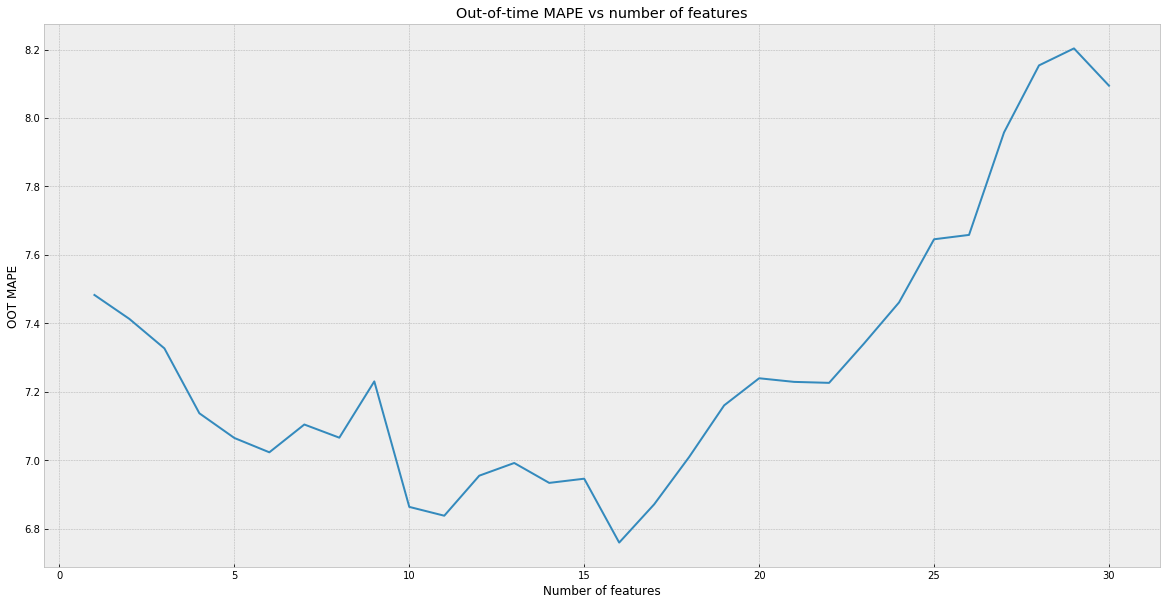

In [581]:
plt.figure(figsize=(20,10))
sns.lineplot(x=range(1,31), y=list(dict_mape.values()))
plt.title("Out-of-time MAPE vs number of features")
plt.xlabel("Number of features")
plt.ylabel("OOT MAPE")

__Отберем первые 10 признаков и применим backward stepwise selection, чтобы оставить 5 лучших признаков.__

__В отличие от forward stepwise selection мы будем поочередно отбрасывать признак и считать OOT MAPE и выбирать признак, отбрасывание которого выльется в самый высокий средний OOT MAPE.__

__Дело в том, что с добавлением признаков OOT MAPE падает немонотонно.__

In [582]:
top10_feat = list(list(dict_mape.keys())[9])

In [583]:
model = LinearRegression()

top5_feat = top10_feat.copy()

In [584]:
top5_feat

['pet_feat',
 'ethylene_glycol_CHN_USD_lag_6',
 'USDCNY_min_lag_4',
 'USDCNY_min_lag_6',
 'brent_min',
 'USDCNY_min_lag_5',
 'ethylene_glycol_EU_EUR',
 'paraxylene_CHN_USD',
 'paraxylene_CHN_USD_lag_1',
 'paraxylene_RT_USD_lag_1']

In [585]:
dict_mape_top5 = {}

for _ in tqdm(range(5)):
    dict_mape_aux = {}
    for feat in top10_feat:
        if feat in top5_feat:
            top5_feat.remove(feat)
            list_mape_aux = []
            for sl in slices:
                i, j, k = sl
                X_train = df_train_sc.iloc[i:j, :]
                X_test = df_train_sc.iloc[j:k, :]
                y_train = y[i:j]
                y_true = y[j:k]
                if len(best_cols) == 1:
                    model.fit(np.array(X_train[top5_feat]).reshape(-1,1), y_train)
                    y_pred = model.predict(np.array(X_test[top5_feat]).reshape(-1,1))
                else:
                    model.fit(X_train[top5_feat], y_train)
                    y_pred = model.predict(X_test[top5_feat])
                list_mape_aux.append(mape(y_true, y_pred))
            top5_feat.append(feat)
            dict_mape_aux[feat] = np.mean(list_mape_aux)
    best_col, best_mape = sorted(dict_mape_aux.items(), key=lambda x: x[1])[0]
    top5_feat.remove(best_col)
    dict_mape_top5[tuple(top5_feat)] = best_mape

100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


In [586]:
top5_feat

['pet_feat',
 'USDCNY_min_lag_6',
 'paraxylene_CHN_USD',
 'paraxylene_CHN_USD_lag_1',
 'paraxylene_RT_USD_lag_1']

__Возьмем отобранные 5 признаков и проанализируем их на мультиколлинеарность.__

__Сделаем это с помощью variance inflation factor (VIF) для каждого признака.__

__Расчёт VIF для i-го признака.__

__1) Обучаем модель, предсказывающую i-ый признак с помощью всех остальных признаков.__

__2) Вычисляем $R^2$ для заданного признака и считаем $VIF_i=1/(1-R^2_i)$.__

__3) Чем выше $VIF_i$, тем выше линейная зависимость признака от остальных признаков.__ 

In [587]:
model = LinearRegression()

In [588]:
X_tr = df_train_sc.iloc[:120,:]

In [589]:
vif_table = pd.DataFrame(columns=['feature', 'vif'], index = range(5))

In [590]:
for num,feat in enumerate(top5_feat):
    ff = top5_feat.copy()
    ff.remove(feat)
    model.fit(X_tr[ff], X_tr[feat])
    vif_table.loc[num, 'feature'] = feat
    vif_table.loc[num, 'vif'] = 1/(1-r2(X_tr[feat], model.predict(X_tr[ff])))

In [591]:
vif_table.sort_values(by="vif")

,feature,vif
1,USDCNY_min_lag_6,1.52848
0,pet_feat,5.82678
2,paraxylene_CHN_USD,12.4882
4,paraxylene_RT_USD_lag_1,30.6809
3,paraxylene_CHN_USD_lag_1,44.7694


__Нарисуем карту корреляций.__

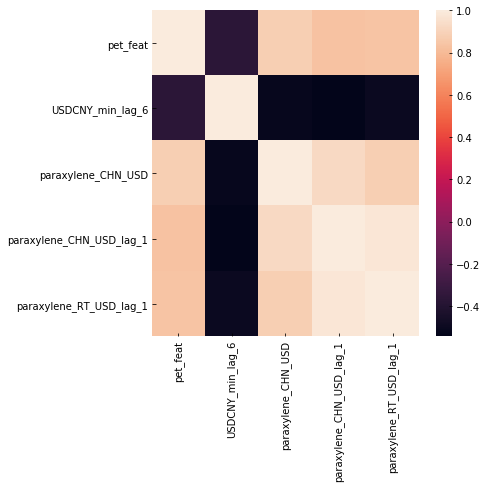

In [592]:
sns.heatmap(X_tr[top5_feat].corr())

__Видно, что цены на параксилен очень сильно скоррелированы между собой и с pet_feat.__

__Оставим две переменные: pet_feat, USDCNY_min_lag_6.__

In [593]:
final_feat = ["pet_feat", "USDCNY_min_lag_6"]

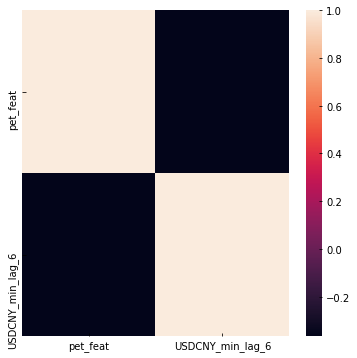

In [594]:
sns.heatmap(X_tr[final_feat].corr())

__Перейдем к выбору лучшей модели.__

In [595]:
# линейная регрессия
model1 = LinearRegression()

# градиентный бустинг
model2 = LGBMRegressor(max_depth=4, n_estimators=300, learning_rate=0.005, random_state=1)
model3 = LGBMRegressor(max_depth=6, n_estimators=300, learning_rate=0.005, random_state=1)

# случайный лес
model4 = RandomForestRegressor(n_estimators=10, random_state=1)
model5 = RandomForestRegressor(n_estimators=15, random_state=1)

# обычный бэггинг линейныйх регрессий
model6 = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, random_state=1)
model7 = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=15, random_state=1)

# обычный бэггинг деревьев
model8 = BaggingRegressor(n_estimators=10, random_state=1)
model9 = BaggingRegressor(n_estimators=15, random_state=1)

In [596]:
models = [model1, model2, model3, model4, model5,
         model6, model7, model8, model9]

In [597]:
table_models = pd.DataFrame(columns = ["validation MAPE"], index = ["model "+str(i) for i in range(1,10)])

In [598]:
X_train = df_train_sc[final_feat].iloc[:120,:]
X_test = df_train_sc[final_feat].iloc[120:,:]

y_train = y[:120]
y_test = y[120:]

In [599]:
for num, mod in enumerate(models):
    mod.fit(X_train, y_train)
    mape_valid = mape(y_test, mod.predict(X_test))
    table_models.loc["model "+str(num+1), "validation MAPE"] = mape_valid

In [600]:
table_models.sort_values(by="validation MAPE")

,validation MAPE
model 8,7.46535
model 4,7.68482
model 5,8.77614
model 9,8.94583
model 7,10.5374
model 6,10.5853
model 1,11.0147
model 2,19.9538
model 3,19.9538


In [601]:
model8.fit(X_train, y_train)
preds_best = model8.predict(X_test)

In [602]:
y_test.index = range(y_test.shape[0]) #приводим индексы к одну и тому же значению

__Визуализируем прогнозы и реальные значения на валидационной выборке.__

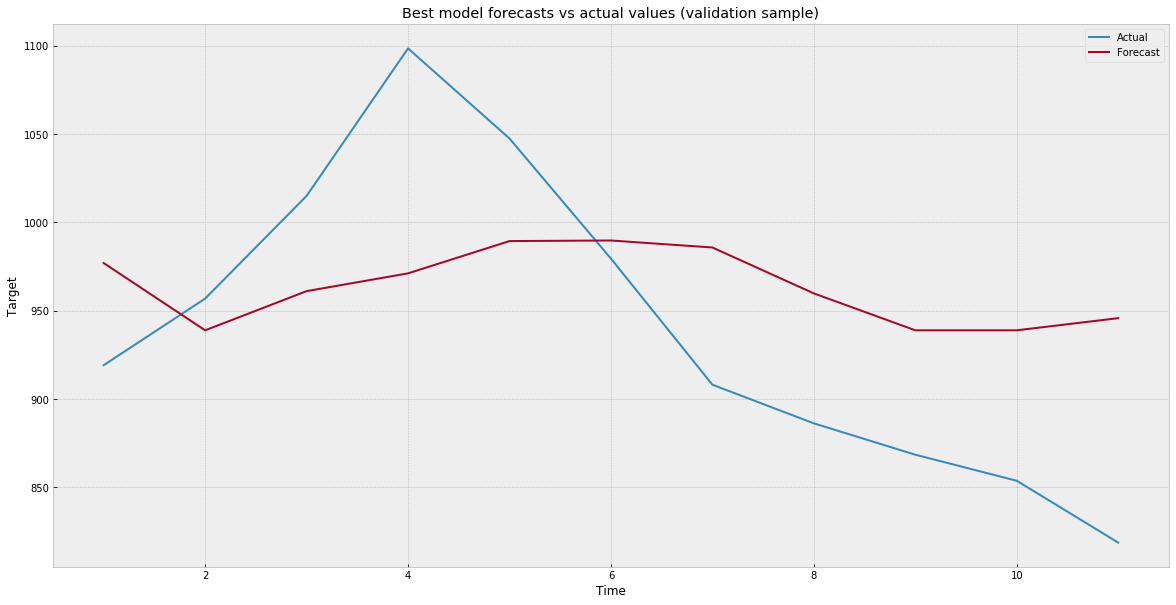

In [603]:
plt.figure(figsize=(20,10))
sns.lineplot(x=range(1,12), y=y_test)
sns.lineplot(x=range(1,12), y=preds_best)
plt.title("Best model forecasts vs actual values (validation sample)")
plt.xlabel("Time")
plt.ylabel("Target")
plt.legend(["Actual", "Forecast"])

In [604]:
mape(y_test, preds_best)

7.465352949605676

In [605]:
df_test_sc[final_feat].shape

(42, 2)

__Перейдем к предсказаниям на тестовой выборке.__

__На тестовой выборке у нас нет информации о pet_feat (двухмесячный лаг целевой переменной), поэтому будем делать предсказания построчно и по мере увеличения кол-ва предсказаний заполнять столбец pet_feat в тестовой выборке.__

In [606]:
model8.fit(df_train_sc[final_feat], y)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=1, verbose=0,
                 warm_start=False)

In [607]:
max_val = df_train["pet_feat"].max() #для шкалирования
min_val = df_train["pet_feat"].min()

In [608]:
preds_test = []

__Алгоритм:__
    
__1) Делаем предсказание для i-го месяца.__

__2) Добавляем предсказание для i-го месяца в список предсказаний.__

__3) Так как мы используем признак pet_feat (значение целевой переменной 2 месяца назад), то мы должны обновить значение pet_feat в тестовой выборке.__

__Для месяца i+2 pet_feat равняется значению целевой переменной 2 месяца назад, а это означает, что pet_feat в строке i+2 равно предсказанию pet_feat для месяца i.__

__Поэтому мы шкалируем предсказание для месяца i и добавляем его в i+2-ую строку столбца pet_feat тестовой выборки.__

In [609]:
for i in range(df_test_sc.shape[0]):
    pred_to_add = model8.predict(np.array(df_test_sc[final_feat].iloc[i, :]).reshape(1, -1))
    preds_test.append(pred_to_add[0])
    if i+2 <= df_test_sc.shape[0]-1:
        df_test_sc.loc[i+2, "pet_feat"] = (pred_to_add - min_val) / (max_val - min_val)

In [610]:
preds_test # список предсказаний для тестовой выборки

[1456.1625,
 990.5125,
 1398.3375,
 900.7041666666667,
 1506.2625,
 895.875,
 1563.7625,
 1024.8,
 1397.775,
 1096.1333333333334,
 1563.95,
 1125.1,
 1454.1,
 1171.675,
 1450.8875,
 1222.075,
 1376.5875,
 1306.725,
 1379.125,
 1215.7125,
 1379.125,
 1222.7,
 1379.125,
 1138.75,
 1379.125,
 1290.75,
 1394.9375,
 1268.9625,
 1451.725,
 1227.6375,
 1375.975,
 1196.25,
 1521.6,
 1307.175,
 1486.9125,
 1332.0,
 1577.85,
 1407.8875,
 1569.0125,
 1410.5625,
 1457.6375,
 1410.5625]

In [515]:
pd.DataFrame(preds_test).to_csv("preds_sibur_01.csv")